In [1]:
import cv2
import os
import numpy as np
from random import shuffle
from tqdm import tqdm


In [2]:
! ls

data  Dog_cat.ipynb  log  models_prev  report.txt


In [3]:
train_dir= 'data/train'
test_dir='data/test1'

In [4]:
IMG_SIZE=150
LR=1e-3



In [5]:
MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'6conv-basic')


In [6]:
def label_img(img):
    word_label=img.split('.')[-3];
    if word_label== 'cat':
        return [1,0]
    elif word_label=='dog':
        return [0,1]
    

In [7]:
def create_train_data():
    train_data=[]
    if 'training_data.npy' in os.listdir():
        train_data=np.load('training_data.npy',allow_pickle=True)
    else:
        for img in tqdm(os.listdir(train_dir)):
            path=os.path.join(train_dir,img)
            img_num=img.split('.')[0]
            label=label_img(img)
            img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            train_data.append([np.array(img),np.array(label)])
        shuffle(train_data)
        train_data=np.array(train_data)
        np.save('training_data.npy',train_data)
    return train_data
        

In [8]:
def create_test_data():
    testing_data=[]
    if 'testing_data.npy' in os.listdir():
        testing_data=np.load('testing_data.npy',allow_pickle=True)
    else:
        for img in tqdm(os.listdir(test_dir)):
            path=os.path.join(test_dir,img)
            img_num=img.split('.')[0]
            img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            testing_data.append([np.array(img),img_num])
        shuffle(testing_data)
        testing_data=np.array(testing_data)
        np.save('testing_data.npy',testing_data)
    return testing_data
        

In [9]:
data=create_train_data()
print(np.shape(data))
test_data=create_test_data()
train_data=data[:15000]
testing_data=data[15000:20000]
validation_data=data[20000:]

  0%|          | 0/12500 [00:00<?, ?it/s]

(25000, 2)


100%|██████████| 12500/12500 [02:08<00:00, 97.20it/s] 


In [10]:
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
# from tensorflow.contrib.keras import keras as keras

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:457: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or 

In [11]:
print(tf.VERSION)

1.1.0


In [12]:
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR,loss ='categorical_crossentropy', name ='targets') 
model = tflearn.DNN(convnet, tensorboard_dir ='log') 

train=train_data
valid=validation_data



In [13]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
valid_x = np.array([i[0] for i in valid]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
valid_y = [i[1] for i in valid] 
print(np.size(X))

337500000


In [14]:
def fit_model_and_save():
    model.fit({'input': X}, {'targets': Y}, n_epoch = 10,validation_set =({'input': valid_x}, {'targets': valid_y}),snapshot_step = 500, show_metric = True, run_id = MODEL_NAME) 
    model.save('models/my_model')
    
if 'models' not in os.listdir():
    ! mkdir models
    fit_model_and_save()
else:
    
    model.load('models/my_model')
    

Training Step: 2349  | total loss: 0.69379 | time: 416.758s
| Adam | epoch: 010 | loss: 0.69379 - acc: 0.4766 -- iter: 14976/15000
Training Step: 2350  | total loss: 0.69360 | time: 464.551s
| Adam | epoch: 010 | loss: 0.69360 - acc: 0.4867 | val_loss: 0.69316 - val_acc: 0.5014 -- iter: 15000/15000
--
INFO:tensorflow:/home/rahul/Desktop/CV_PROJECT/models/my_model is not in all_model_checkpoint_paths. Manually adding it.


In [15]:
os.listdir('models')

['checkpoint',
 'my_model.data-00000-of-00001',
 'my_model.meta',
 'my_model.index']

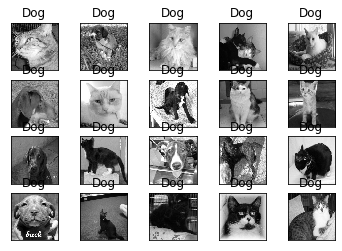

In [16]:
import matplotlib.pyplot as plt 

  
fig = plt.figure() 
  
for num, data in enumerate(test_data[:20]): 
    # cat: [1, 0] 
    # dog: [0, 1] 
      
    img_num = data[1] 
    img_data = data[0] 
      
    y = fig.add_subplot(4, 5, num + 1) 
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
  
    
    model_out = model.predict([data])[0] 
      
    if np.argmax(model_out) == 1: str_label ='Dog'
    else: str_label ='Cat'
          
    y.imshow(orig, cmap ='gray') 
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
plt.show() 

In [17]:
model.predict([test_data[0][0].reshape(IMG_SIZE,IMG_SIZE,1)])

array([[0.49613005, 0.50387   ]], dtype=float32)

In [ ]:
def get_results():
    #use testing_data to get results
    num_data=np.size(testing_data)
    num_correct=0
    cond_positive=0
    cond_neg=0
    pred_positive=0
    pred_neg=0
    true_pos=0
    false_pos=0
    tpr=[]
    fpr=[]
    for i in testing_data:
        img=i[0].reshape(IMG_SIZE,IMG_SIZE,1)
        label=i[1]
        if label[0]==0:
            cond_positive=cond_positive+1
        else:
            cond_neg=cond_neg+1
            
            
            
            
        prediction=model.predict([img])
        if np.argmax(prediction)==1:    # prediction is dog
            pred_positive=pred_positive+1
            if label[0]==0:
                num_correct=num_correct+1
                true_pos=true_pos+1
            else:
                false_pos=false_pos+1
                
                
                
        else:      #prediction is cat
            pred_neg=pred_neg+1
            if label[0]==1:
                num_correct=num_correct+1
        fpr.append(0 if cond_neg==0 else false_pos/cond_neg)
        tpr.append(0 if cond_positive==0 else true_pos/cond_positive)
    return [num_correct/num_data,[tpr,fpr]]    

[acc,grp]=get_results()
    

In [ ]:
print(acc)

In [ ]:
plt.plot(grp[0],grp[1])
    